# ALZHEIMER'S DISEASE PREDICTION (MMSE SCORE)

This notebook aims to predict the decrease in MMSE (Mini Mental State Examination) scores over a 2 year period with baseline data using several Machine Learning Models. The Mini Mental State Examination test is a 30-point questionnaire that is used extensively in clinical and research settings to measure cognitive impairment. Predicting a patient's future MMSE test score will aid in early detection and treatment. 

## The Training Data to be Preprocessed: 
The training data consist of individuals participating in the Alzheimer’s Disease Neuroimaging Initiative (ADNI), which is a longitudinal multicenter study established in 2004 with the goal of detecting AD at an early stage, tracking disease progression through biomarkers, supporting advances in AD intervention, prevention and treatment, and providing a resource for AD research. The study has grown to >1600 participants with mild cognitive impairment (MCI),ranging from Early MCI (EMCI) to Late MCI (LMCI), Alzheimer's Disease (AD) and elderly, cognitively normal (CN) control subjects that have been recruited over three phases ADNI 1, ADNI GO and ADNI 2.

  ### -Descriptions  
    - RID: Participant roster ID
    - PTID: Participant ID
    - VISCODE: Visit code
    - EXAMDATE: Examination Date
    - DX.bl: Diagnosis at baseline
    - AGE: Age at baseline
    - PTGENDER: Sex
    - PTEDUCAT: Years of Education
    - APOE4: ApoE4 genotype
    - MMSE: MMSE score
    - APOE Genotype: APOE allele 1 and allele 2 genotypes

### The Goal of this Research is to find a way to accurately predict the change in MMSE scores using easily (and cheap) data that anyone can get. A major problem is the cost of healthcare, so a program that can predict the future MMSE score using this low cost data will help immensely, as an average MRI can cost around 4,000 dollars  

In [692]:
import numpy as np
import sklearn as sk
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math 

from numpy import mean
from numpy import std
from numpy import absolute
from math import sqrt
from numpy.random import randn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold

warnings.filterwarnings('ignore')
%matplotlib inline

In [693]:
data = pd.read_csv("ADNI_Training_Q1_APOE_July22.2014.csv") # Get the Data
data.head(4) # Peak at the data 

,RID,PTID,VISCODE,EXAMDATE,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,APOE Genotype
0,5,011_S_0005,bl,9/7/05,CN,73.7,Male,16,0,29,"3,3"
1,5,011_S_0005,m24,9/7/07,CN,73.7,Male,16,0,29,"3,3"
2,6,100_S_0006,bl,11/29/05,LMCI,80.4,Female,13,0,25,"3,3"
3,6,100_S_0006,m24,11/8/07,LMCI,80.4,Female,13,0,26,"3,3"


In [694]:
data = data.drop(['RID', 'PTID', 'VISCODE', 'EXAMDATE'], axis=1) # Remove Unneccesary Data
categorical_variables = ['DX.bl', 'PTGENDER', 'APOE Genotype']
numerical_variables = ['AGE','PTEDUCAT', 'APOE4', 'MMSE']
for var in categorical_variables:
    data = pd.concat([data, pd.get_dummies(data[var])], axis=1)
    data = data.drop(var, axis=1)
# Implements One Hot Encoder for the purpose of replacing the Categorical Values with Numerical Values to implement regression models

Preprocessing the Data: Removing the checkup data and adding a column to indicate the change of MMSE. (Final MMSE score - Baseline MMSE score = MMSE_NEW_SCORE)

In [695]:
r, c = data.shape
MMSE_SCORE = []
for var in range(0,r):
    if (var % 2) == 0:
        continue
    MMSE_SCORE.append(data.at[var,'MMSE'] - data.at[var - 1,'MMSE'])
data = data[::2]
data.insert(16, "MMSE_NEW_SCORE",MMSE_SCORE, True) 
data.head(2)

,AGE,PTEDUCAT,APOE4,MMSE,AD,CN,EMCI,LMCI,Female,Male,"2,2","2,3","2,4","3,3","3,4","4,4",MMSE_NEW_SCORE
0,73.7,16,0,29,0,1,0,0,0,1,0,0,0,1,0,0,0
2,80.4,13,0,25,0,0,0,1,1,0,0,0,0,1,0,0,1


HEAT MAP :



,AGE,PTEDUCAT,APOE4,MMSE,AD,CN,EMCI,LMCI,Female,Male,"2,2","2,3","2,4","3,3","3,4","4,4",MMSE_NEW_SCORE
AGE,1.000000,-0.038884,-0.189671,-0.093013,0.069228,0.124587,-0.219967,-0.001479,-0.088248,0.088248,-0.022703,-0.026467,-0.017410,0.162223,-0.037191,-0.177591,0.072620
PTEDUCAT,-0.038884,1.000000,-0.092994,0.265082,-0.173562,0.101674,0.035978,0.006249,-0.183832,0.183832,0.026042,-0.029601,0.009226,0.092550,-0.038442,-0.075040,0.049447
APOE4,-0.189671,-0.092994,1.000000,-0.274455,0.220970,-0.281807,-0.059225,0.150278,-0.009488,0.009488,-0.030522,-0.230151,0.088848,-0.788255,0.473429,0.717538,-0.215819
MMSE,-0.093013,0.265082,-0.274455,1.000000,-0.704741,0.468009,0.177233,-0.052516,-0.007680,0.007680,0.037638,0.086369,-0.002139,0.215955,-0.164578,-0.174477,0.300336
AD,0.069228,-0.173562,0.220970,-0.704741,1.000000,-0.295818,-0.197429,-0.324883,0.052875,-0.052875,-0.015790,-0.091051,-0.006506,-0.172739,0.153196,0.125938,-0.388214
CN,0.124587,0.101674,-0.281807,0.468009,-0.295818,1.000000,-0.305786,-0.503192,0.043992,-0.043992,0.053379,0.103507,-0.050333,0.218624,-0.166949,-0.170043,0.262275
EMCI,-0.219967,0.035978,-0.059225,0.177233,-0.197429,-0.305786,1.000000,-0.335830,-0.003949,0.003949,-0.016323,0.055038,-0.035639,0.038258,-0.043227,-0.023715,0.165391
LMCI,-0.001479,0.006249,0.150278,-0.052516,-0.324883,-0.503192,-0.335830,1.000000,-0.080080,0.080080,-0.026860,-0.073700,0.081712,-0.109553,0.078324,0.086925,-0.086357
Female,-0.088248,-0.183832,-0.009488,-0.007680,0.052875,0.043992,-0.003949,-0.080080,1.000000,-1.000000,-0.030244,-0.029617,0.004592,0.031427,-0.017706,0.002436,-0.036610
Male,0.088248,0.183832,0.009488,0.007680,-0.052875,-0.043992,0.003949,0.080080,-1.000000,1.000000,0.030244,0.029617,-0.004592,-0.031427,0.017706,-0.002436,0.036610


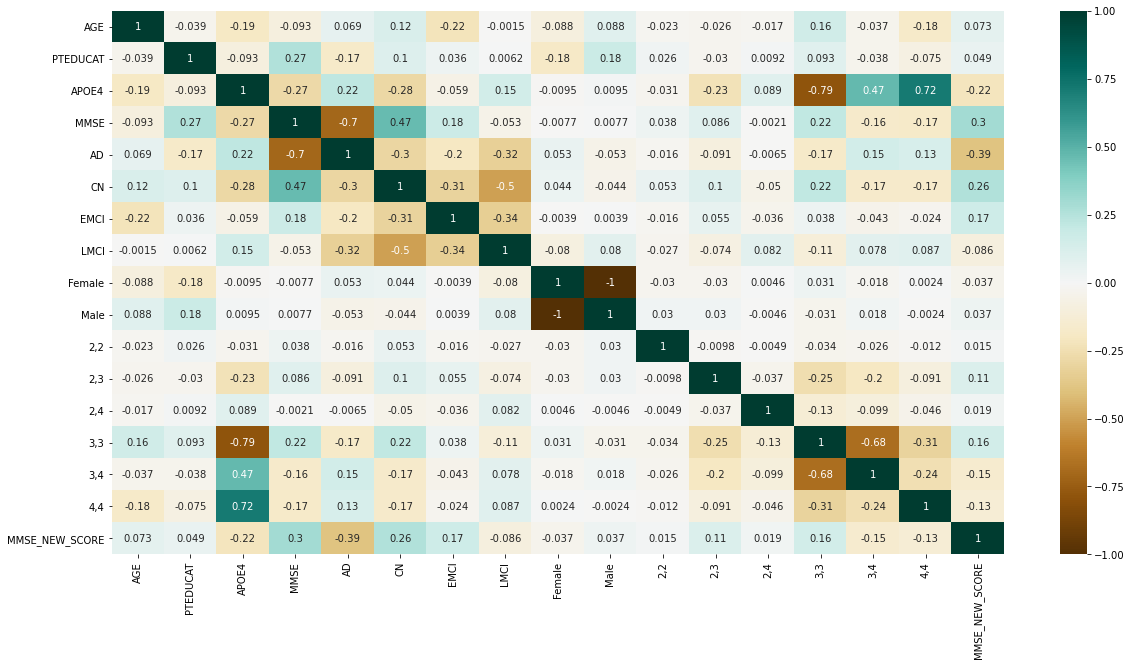

In [696]:
print('HEAT MAP :\n')

plt.figure(figsize=(20,10))
c= data.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

This map shows how impactful the variables are in determining the new MMSE Score. 

#### Model 1 : Linear Regression using the most impactful variables 

In [697]:
X = data.drop(["MMSE_NEW_SCORE"], axis=1)
y = data["MMSE_NEW_SCORE"]
r = len(y)
for var in range(0,r): #Edited so that a decline of 5 points is the largest 
    if (var % 2 == 1):
        continue
    if (y.at[var] < -5):
        y.at[var] = -5
    if (y.at[var] > 5):
        y.at[var] = 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120)

In [698]:
X_train.shape

(613, 16)

In [699]:
X_test.shape


(154, 16)

In [700]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test) #Scaling data
model = LinearRegression()
model.fit(train_scaled, y_train)
mse = mean_squared_error(y_train, model.predict(train_scaled))
mae = mean_absolute_error(y_train, model.predict(train_scaled))


In [701]:
print("mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))
print ("\n")
print("mae = mean absolute error. (MAE) is a measure of errors between paired observations expressing the same phenomenon. ")
print("mse = mean squared error. (MSE) is a measure of the average of the squares of the errors. ")
print("rmse = Root Mean Square Error. (RMSE) is the standard deviation of the residuals (prediction errors).")

mse =  2.19052003  & mae =  1.33190629  & rmse =  1.48004055


mae = mean absolute error. (MAE) is a measure of errors between paired observations expressing the same phenomenon. 
mse = mean squared error. (MSE) is a measure of the average of the squares of the errors. 
rmse = Root Mean Square Error. (RMSE) is the standard deviation of the residuals (prediction errors).


#### Model 2 : Decision Trees & Random Forests

In [702]:
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()

In [703]:
tree_model.fit(train_scaled, y_train)
rf_model.fit(train_scaled, y_train)

RandomForestRegressor()

In [704]:
tree_mse = mean_squared_error(y_train, tree_model.predict(train_scaled))
tree_mae = mean_absolute_error(y_train, tree_model.predict(train_scaled))
rf_mse = mean_squared_error(y_train, rf_model.predict(train_scaled))
rf_mae = mean_absolute_error(y_train, rf_model.predict(train_scaled))
print("Decision Tree training mse = ",tree_mse," & mae = ",tree_mae," & rmse = ", sqrt(tree_mse))
print("Random Forest training mse = ",rf_mse," & mae = ",rf_mae," & rmse = ", sqrt(rf_mse))

Decision Tree training mse =  0.004078303425774877  & mae =  0.004893964110929853  & rmse =  0.06386159585991316
Random Forest training mse =  1.332707384882719  & mae =  0.7902637302882001  & rmse =  1.1544294629308103


In [705]:
tree_test_mse = mean_squared_error(y_test, tree_model.predict(test_scaled))
tree_test_mae = mean_absolute_error(y_test, tree_model.predict(test_scaled))
rf_test_mse = mean_squared_error(y_test, rf_model.predict(test_scaled))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(test_scaled))
print("Decision Tree test mse = ",tree_test_mse," & mae = ",tree_test_mae," & rmse = ", sqrt(tree_test_mse))
print("Random Forest test mse = ",rf_test_mse," & mae = ",rf_test_mae," & rmse = ", sqrt(rf_test_mse))

Decision Tree test mse =  14.844155844155845  & mae =  2.5194805194805197  & rmse =  3.852811420788181
Random Forest test mse =  8.457144037698415  & mae =  2.163306277056277  & rmse =  2.908116922975831


In [706]:
explained_variance_score(y_test, tree_model.predict(test_scaled))

-0.42718955962881644

In [707]:
explained_variance_score(y_test, rf_model.predict(test_scaled))

0.18773105069066431

#### Model 3: Neural Networks & K Nearest Neighbors

In [708]:
model = MLPClassifier()


In [709]:
model.fit(train_scaled, y_train)


MLPClassifier()

In [710]:
accuracy_score(y_train, model.predict(train_scaled))

0.3931484502446982

In [711]:
accuracy_score(y_test, model.predict(test_scaled))

0.22727272727272727

In [712]:
model = KNeighborsRegressor()
model.fit(train_scaled, y_train)


KNeighborsRegressor()

In [713]:
mse = mean_squared_error(y_train, model.predict(train_scaled))
mae = mean_absolute_error(y_train, model.predict(train_scaled))

In [714]:
test_mse = mean_squared_error(y_test, model.predict(test_scaled))
test_mae = mean_absolute_error(y_test, model.predict(test_scaled))
print("mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))

mse =  10.586493506493508  & mae =  2.2311688311688305  & rmse =  3.2536892147981047


#### Model 4: ElasticNet

In [715]:
model = ElasticNet(alpha=0.001, l1_ratio=1)

In [716]:
cv = RepeatedKFold(n_splits=7, n_repeats=5, random_state=1)

In [717]:
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = absolute(scores)

In [718]:
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 1.01558442 (0.182) 


# Conclusion

The ElasticNet algorithm produces the most accurate model for predicting the change in MMSE score and we will use it to determine the classification accuracy 

In [719]:
model.fit(X, y)
arr = model.predict(X)
r = len(arr)
for var in range(0,r):
    if (arr[var] > 0):
        if (arr[var] - math.floor(arr[var]) > 0.5):
            arr[var] = math.ceil(arr[var])
        else: 
            arr[var] = math.floor(arr[var])
    if (arr[var] < 0):
        if (absolute(arr[var]) - absolute(math.ceil(arr[var])) > 0.5):
            arr[var] = math.floor(arr[var])
        else: 
            arr[var] = math.ceil(arr[var])

The above code is to convert the scores to whole numbers (-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5) 

In [720]:
r = len(arr)
count = 0
t2 = 0
for var in range(0,r):
    if (arr[var] == y[t2]): 
        count = count + 1
    t2 = t2 + 2

print("Classification accuracy: \n")
print(count/r)

Classification accuracy: 

0.4312751285071022


##### The Classification Accuracy for the most optimal machine learning model is 0.4312751285071022, which means that the model will be able to predict the decrease in MMSE scores over a 2 year period perfectly around 50% of the time. 

In [721]:
r = len(arr)
count = 0
t2 = 0
for var in range(0,r):
    if (arr[var] == y[t2]): 
        count = count + 1
    if (arr[var] == y[t2] + 1): 
        count = count + 1
    if (arr[var] == y[t2] - 1): 
        count = count + 1
    t2 = t2 + 2

print("Classification accuracy: \n")
print(count/r)

Classification accuracy: 

0.824006518904824


##### When we check for predicting the decrease in MMSE score by accepting a margin of error of 1 we have a classification accuracy of 0.824006518904824. This means that we can predict the decrease of an MMSE score in a patient over a time of 2 years (with a Margin of Error of 1) with an accuracy of around 82%